# States analysis

'''Created on Thu 03 Sep 2020'''


In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165           ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 2
period = int(3 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        if mouse == 32364:
            fixed = 'LR'
        if mouse == 56165:
            fixed = 'UR'
    else:
        if session_now == 2:
            task = 'STABLE'
            if mouse == 32364:
                fixed = 'UL and UR'
            if mouse == 56165:
                fixed = 'UR and LR (verify)'
        else:
            task = 'RANDOM'
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'UL'
            
if mouse == 32366:
    sessions = [3,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/states_analysis/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
day = 1
for trial in [1,6,11,16,21]:
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                          '.' + f'{0}' + '_10.pkl'
    timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
    timeline_info = pickle.load(timeline_file)
    ##normalize neural activity
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = activity.shape[1]
    resample_timeline = timeline_1/re_sf

    timeline_list.append(resample_timeline)
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_event_' + f'{re_sf}' + '.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    #c = np.linspace(0, 20, len(behaviour))
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    resample_timeline = timeline_1/re_sf
    
    behaviour_list.append(resample_beh1)
    day = day + 1

In [5]:
# for each day creates a list that counts and saves times of different events.
# We will consider events here as resting period, navigation periods and object exploration periods.
# Later on will also consider different objects in the exploration periods

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [6]:
# separte events belonging to each of the behavioural conditions

behavioural_events_days_list = []
conditions = [ 'Resting', 'Navigation', 'Object_exploration']

for day in range(len(behaviour_list)):
    events = np.array(events_day_list[day])
    events[np.where(events>1)] = 2
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])

    object_list = []
    for target in [0,1,2]:
        period1 = period
        if target == 0:
            period1 = period_resting
        object_data = []
        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        for event in events_duration:
            if event > period:
                object_data.append(activity_list[day][:,time[i]:time[i]+period1])
            i = i + 1
        object_list.append(object_data)
    behavioural_events_days_list.append(object_list)

In [7]:
population_vector = []
for day in range(len(behaviour_list)):
    mean_over_trials_list = []
    for i in range(len(behavioural_events_days_list[day])):
        mean_over_trials= np.mean(behavioural_events_days_list[day][i], axis= 0)
        if mean_over_trials.shape:
            mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))#/np.max(np.mean(mean_over_trials,axis=1)))
    population_vector.append(mean_over_trials_list)

/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melisa/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# we compute for each day a matrix containing all the activity
matrix = []
matrix_elements_size= []
neural_corr = []
temporal_corr = []
for day in range(len(behavioural_events_days_list)):
    matrix_list = []
    matrix_size = 0
    matrix_limits = []
    for i in range(len(behavioural_events_days_list[day])):
        if behavioural_events_days_list[day][i]: 
            period1 = period
            if i == 0:
                period1 = period_resting
            mean_over_trials =  np.mean(behavioural_events_days_list[day][i], axis= 0)            
            matrix1 = np.zeros((len(mean_over_trials),period1*len(behavioural_events_days_list[day][i])))
            for j in range(len(behavioural_events_days_list[day][i])):
                matrix1[:,j*period1:(j+1)*period1] = behavioural_events_days_list[day][i][j]
            matrix_list.append(matrix1)
            matrix_limits.append([matrix_size, matrix_size + period1*len(behavioural_events_days_list[day][i])])
            matrix_size = matrix_size + period1*len(behavioural_events_days_list[day][i])
    auxiliar_matrix = np.zeros((len(mean_over_trials),matrix_size))
    for i in range(len(matrix_list)):
        auxiliar_matrix[:,matrix_limits[i][0]:matrix_limits[i][1]] = matrix_list[i]
    matrix.append(auxiliar_matrix)
    corr_matrix = stats.corr_matrix(neural_activity = auxiliar_matrix)
    neural_corr.append(corr_matrix)
    corr_matrix2= stats.corr_matrix(neural_activity = auxiliar_matrix.T)
    temporal_corr.append(corr_matrix2)
    matrix_elements_size.append(matrix_limits)


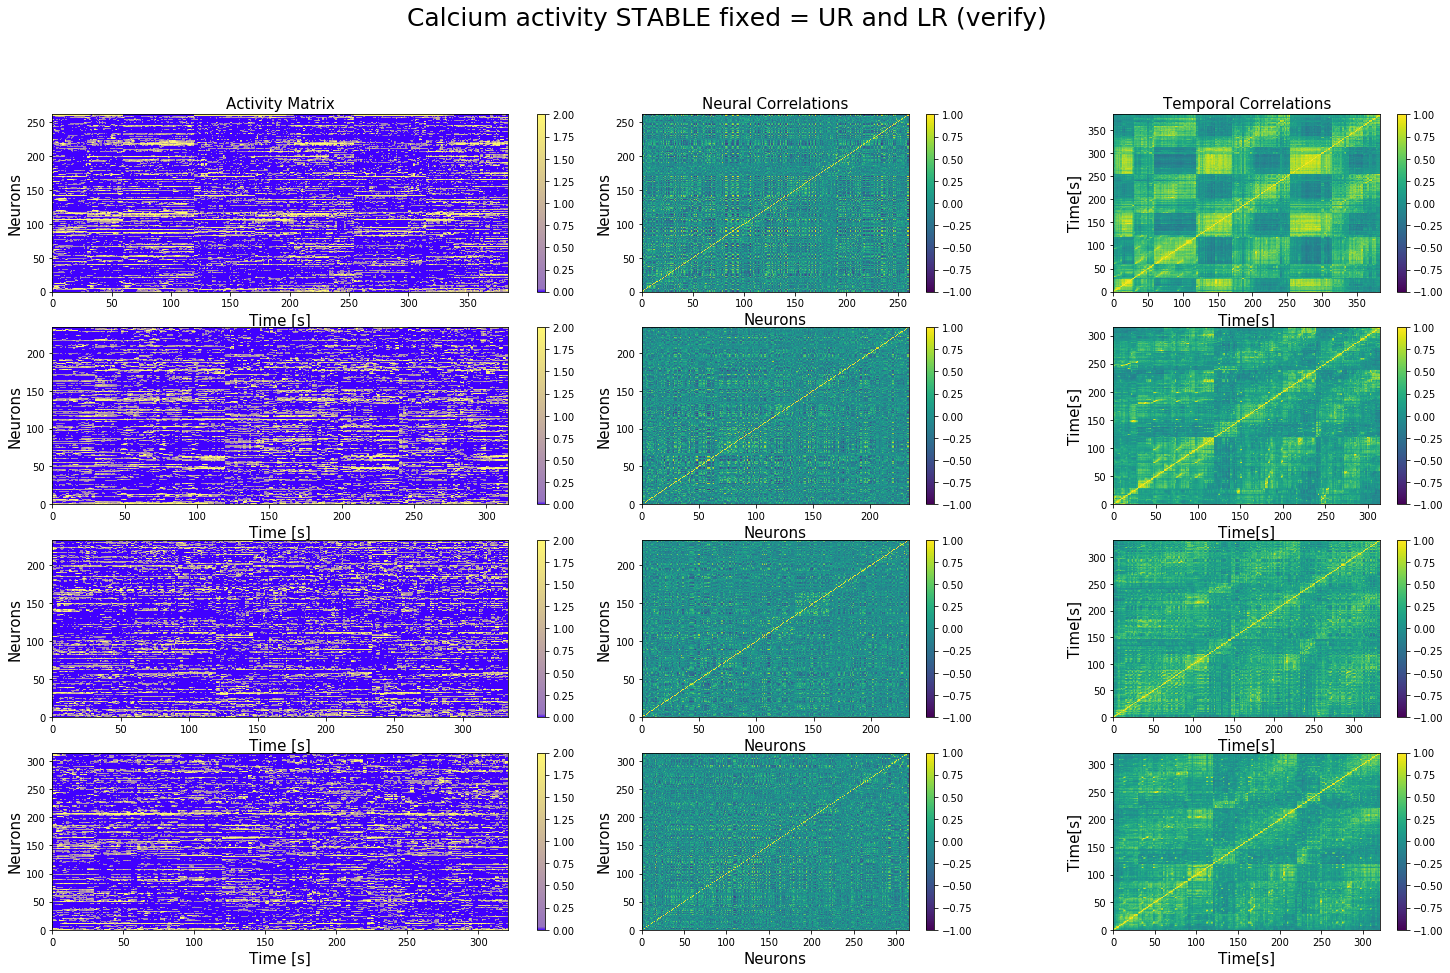

In [9]:
import matplotlib as m

cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = m.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

vmin= 0
vmax=2

vmin_corr= -1
vmax_corr=1

fig = plt.figure()
gs = plt.GridSpec(4, 12)

i=0
for day in range(len(matrix)-1):
    ax = fig.add_subplot(gs[day,0:5])
    #ax.set_title()
    ax.set_ylabel('Neurons', fontsize = 15)
    ax.set_xlabel('Time [s]', fontsize = 15)
    mesh = ax.pcolormesh(matrix[day], cmap = cm)
    mesh.set_clim(vmin,vmax)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Activity Matrix', fontsize = 15)
    
    ax = fig.add_subplot(gs[day, 5:8])
    ax.set_ylabel('Neurons', fontsize = 15)
    ax.set_xlabel('Neurons', fontsize = 15)
    mesh = ax.pcolormesh(neural_corr[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Neural Correlations', fontsize = 15)
      
        
    ax = fig.add_subplot(gs[day, 9:12])
    ax.set_ylabel('Time[s]', fontsize = 15)
    ax.set_xlabel('Time[s]', fontsize = 15)
    mesh = ax.pcolormesh(temporal_corr[day], cmap = 'viridis')
    mesh.set_clim(vmin_corr,vmax_corr)
    fig.colorbar(mesh,ax=ax)
    if day == 0:
        ax.set_title('Temporal Correlations', fontsize = 15)
    
    
#fig.tight_layout()
fig.set_size_inches(25,15)
fig.suptitle('Calcium activity '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'calcium_activity_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


In [19]:
### compute pca ver matrix of different days
neural_pca_components= []
neural_explained_variance = []
neural_transform=[]
neural_pca = PCA(n_components=4)

temporal_pca = PCA(n_components=4)
data_transform = []
temporal_explained_variance = []

for i in range(len(matrix)):
    neural_pca.fit(matrix[i].T)
    neural_pca_components.append(neural_pca.components_)
    neural_transform.append(neural_pca.transform(matrix[i].T))
    neural_explained_variance.append(neural_pca.explained_variance_ratio_)
    
    temporal_pca.fit(matrix[i])
    data_transform.append(temporal_pca.transform(matrix[i]))
    temporal_explained_variance.append(temporal_pca.explained_variance_ratio_)
    

In [20]:
beh = ['Rest','Nav','Exp']
#comp= ['1st','2nd','3rd','4th','5th']
comp= ['1st','2nd','3rd','4th']

distance_list = []
for day in range(len(matrix)-1): 
    distance_matrix = np.zeros((data_transform[day].shape[1],len(population_vector[day])))
    for component in range(data_transform[day].shape[1]):
        for behaviour in range(len(population_vector[day])):
            distance = np.linalg.norm(data_transform[day][:,component]/np.linalg.norm(data_transform[day][:,component])-
                                      population_vector[day][behaviour]/np.linalg.norm(population_vector[day][behaviour]))
            distance_matrix[component,behaviour] = distance
    distance_list.append(distance_matrix)

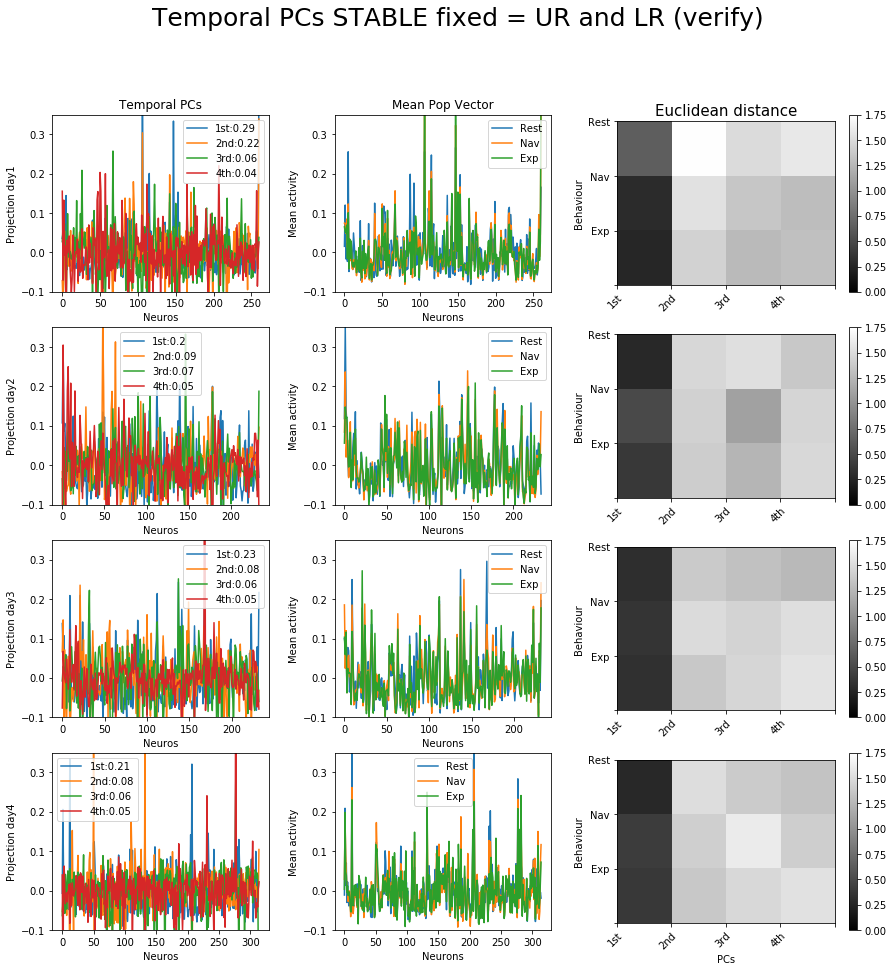

In [24]:
fig = plt.figure()
gs = plt.GridSpec(4, 15)

vmin= 0
vmax=1.75

for day in range(len(matrix)-1): 
    
    ax = fig.add_subplot(gs [day,0:4])
    
    ax.plot(data_transform[day][:,0]/np.linalg.norm(data_transform[day][:,0]))
    ax.plot(data_transform[day][:,1]/np.linalg.norm(data_transform[day][:,1]))
    ax.plot(data_transform[day][:,2]/np.linalg.norm(data_transform[day][:,2]))
    ax.plot(data_transform[day][:,3]/np.linalg.norm(data_transform[day][:,3]))    
    ax.legend([comp[0] + ':' + f'{round(temporal_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(temporal_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(temporal_explained_variance[day][2],2)}',
              comp[3] + ':' + f'{round(temporal_explained_variance[day][3],2)}'])
    if day == 0:
        ax.set_title('Temporal PCs')
    ax.set_xlabel('Neuros')
    ax.set_ylabel('Projection day' + f'{day+1}' )
    ax.set_ylim([-0.1, 0.35])
    
    ax = fig.add_subplot(gs [day,5:9])
    ax.plot(population_vector[day][0]/np.linalg.norm(population_vector[day][0]))
    ax.plot(population_vector[day][1]/np.linalg.norm(population_vector[day][1]))
    ax.plot(population_vector[day][2]/np.linalg.norm(population_vector[day][2]))
    ax.legend(beh)
    if day == 0:
        ax.set_title('Mean Pop Vector')
    ax.set_xlabel('Neurons')
    ax.set_ylabel('Mean activity')
    ax.set_ylim([-0.1, 0.35])
    
    
    ax1 = fig.add_subplot(gs[day, 10:15])
    if day == 0:
        ax1.set_title('Euclidean distance', fontsize = 15)
    x = ax1.imshow(distance_list[day].T, cmap = 'gray')
    
    x.set_clim(vmin,vmax)
    x_pos = np.arange(-0.5,len(comp)+0.5)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(comp)
    
    y_pos = np.arange(-0.5,len(beh)+0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(beh)
    ax1.set_ylabel('Behaviour')
    if day == 3:
        ax1.set_xlabel('PCs')
    
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fig.colorbar(x, ax=ax1)    

#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Temporal PCs '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'temporal_pcs_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)


In [13]:
### compute activity matrix for days and conditions
matrix_behaviour = []
matrix_behaviour_size = []
for day in range(len(behavioural_events_days_list)):
    matrix_list = []
    matrix_list_size = []
    for i in range(len(behavioural_events_days_list[day])):
        if behavioural_events_days_list[day][i]: 
            period1 = period
            if i == 0:
                period1 = period_resting
            mean_over_trials =  np.mean(behavioural_events_days_list[day][i], axis= 0)
            mean_firing_rate = np.mean(mean_over_trials, axis = 1)
            positions = np.flip(np.argsort(mean_firing_rate))
            positions1 = positions[np.where(mean_firing_rate[positions])]
            matrix1 = np.zeros((positions1.shape[0],period1*len(behavioural_events_days_list[day][i])))
            
            for j in range(len(behavioural_events_days_list[day][i])):
                matrix1[:,j*period1:(j+1)*period1] = behavioural_events_days_list[day][i][j][positions1,:]
            
            matrix_list.append(matrix1)
            matrix_list_size.append(matrix1.shape)
    matrix_behaviour.append(matrix_list)
    matrix_behaviour_size.append(matrix_list_size)

In [14]:
## here we will measure the distance of the population vectors in the different condion with
##the 5 principal components that pops out from PCA
complete_distance = []
for day in range(len(matrix_behaviour)-1):
    day_distance = []
    for component in range(data_transform[day].shape[1]):
        component_distance = []
        for condition in range(len(matrix_behaviour[day])):
            condition_distance = []
            for i in range(matrix_behaviour[day][condition].shape[1]):
                distance = np.linalg.norm(matrix_behaviour[day][condition][:,i]/np.linalg.norm(matrix_behaviour[day][condition][:,i])
                                          -data_transform[day][:,component]/np.linalg.norm(np.linalg.norm(data_transform[day][:,component])))
                condition_distance.append(distance)
            component_distance.append(condition_distance)
        day_distance.append(component_distance)
    complete_distance.append(day_distance)

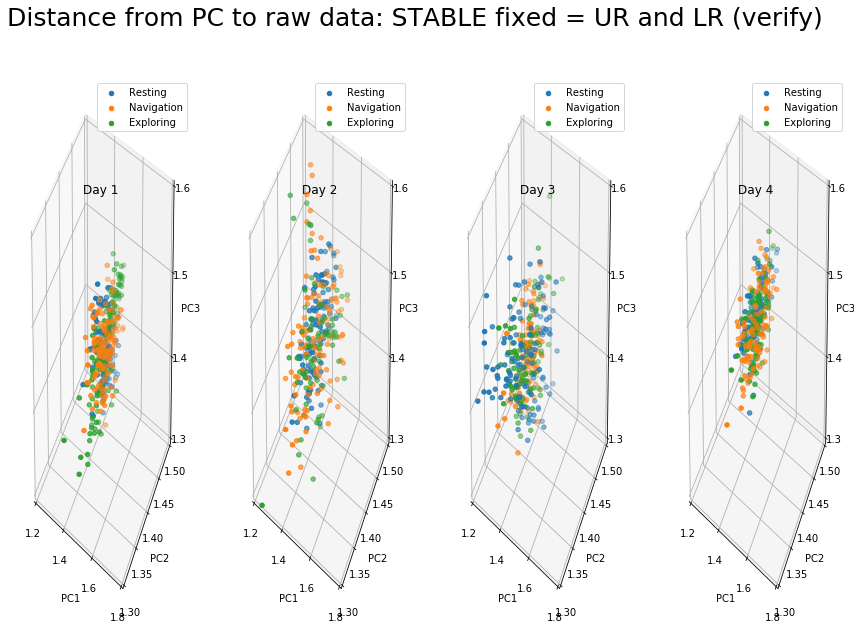

In [15]:
fig = plt.figure()
gs = plt.GridSpec(1, 4)

for day in range(len(complete_distance)):
    ax1 = fig.add_subplot(gs [0,day],projection='3d')
    #ax2 = fig.add_subplot(gs [1,day],projection='3d')
    for beh in range(3):
        ax1.scatter(complete_distance[day][0][beh],complete_distance[day][1][beh],complete_distance[day][2][beh])
        #ax2.scatter(complete_distance[day][0][beh],complete_distance[day][3][beh],complete_distance[day][4][beh])

        ax1.set_xlim([1.2,1.8])
        ax1.set_ylim([1.3,1.5])
        ax1.set_zlim([1.3,1.6])
        
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        ax1.set_zlabel('PC3')
        
        ax1.set_title('Day ' + f'{day+1}')

        ax1.legend(['Resting','Navigation','Exploring'])
        #ax2.set_xlim([1.2,1.8])
        #ax2.set_ylim([1.3,1.5])
        #ax2.set_zlim([1.3,1.5])

#fig.tight_layout()
fig.set_size_inches(15,10)

fig.suptitle('Distance from PC to raw data: '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'distance_pcs_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)

In [16]:
neural_pca_components[0].shape
    

print(matrix_elements_size)

[[[0, 120], [120, 255], [255, 384]], [[0, 120], [120, 240], [240, 315]], [[0, 120], [120, 234], [234, 333]], [[0, 120], [120, 222], [222, 321]], [[0, 30], [30, 51]]]


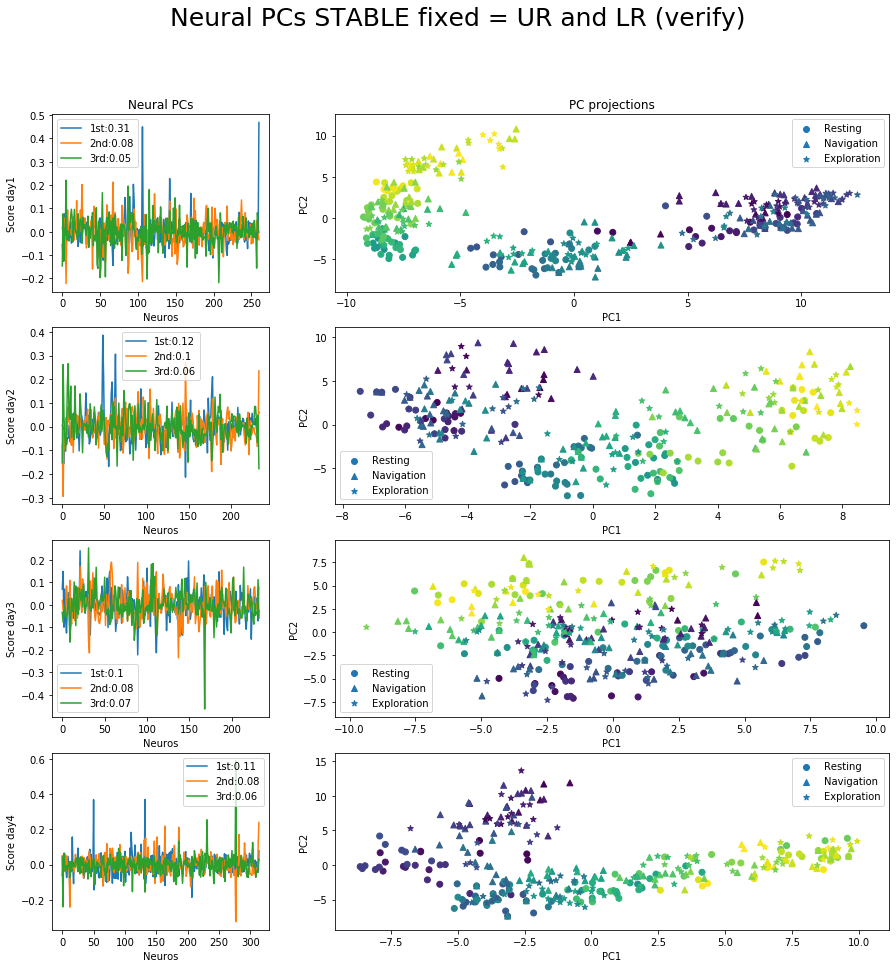

In [18]:
fig = plt.figure()
gs = plt.GridSpec(4, 15)

markers = ['o', '^', '*']

for day in range(len(matrix)-1): 
    
    ax = fig.add_subplot(gs [day,0:4])
    
    ax.plot(neural_pca_components[day][0,:]/np.linalg.norm(neural_pca_components[day][0,:]))
    ax.plot(neural_pca_components[day][1,:]/np.linalg.norm(neural_pca_components[day][1,:]))
    ax.plot(neural_pca_components[day][2,:]/np.linalg.norm(neural_pca_components[day][2,:]))
   
    ax.legend([comp[0] + ':' + f'{round(neural_explained_variance[day][0],2)}', 
               comp[1] + ':' + f'{round(neural_explained_variance[day][1],2)}',
              comp[2] + ':' + f'{round(neural_explained_variance[day][2],2)}'])
    if day == 0:
        ax.set_title('Neural PCs')
    ax.set_xlabel('Neuros')
    ax.set_ylabel('Score day' + f'{day+1}' )
    #ax.set_ylim([-0.1, 0.35])
    
    ax = fig.add_subplot(gs [day,5:15])#, projection = '3d')
    for beh in range(len(matrix_elements_size[day])):
        color1 = np.linspace(0, 20, len(neural_transform[day][matrix_elements_size[day][beh][0]:matrix_elements_size[day][beh][1],0]))
        ax.scatter(neural_transform[day][matrix_elements_size[day][beh][0]:matrix_elements_size[day][beh][1],0],
                   neural_transform[day][matrix_elements_size[day][beh][0]:matrix_elements_size[day][beh][1],1],
                   #neural_transform[day][matrix_elements_size[day][beh][0]:matrix_elements_size[day][beh][1],2],
                  marker = markers[beh], c = color1)
    ax.legend(['Resting','Navigation','Exploration'])
    if day == 0:
        ax.set_title('PC projections')
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
#fig.tight_layout()
fig.set_size_inches(15,15)

fig.suptitle('Neural PCs '+ task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'neural_pcs_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_days.png'
fig.savefig(figure_name)
